## Imports

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import keras
from IPython import display
#from scipy.misc import imshow
from scipy.misc.pilutil import imread
from keras.preprocessing import image
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend

Using TensorFlow backend.


## Load dataset

In [2]:
(x1, y1), (x2, y2) = cifar10.load_data()

In [3]:
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((y1, y2), axis=0)

In [4]:
del x1, y1, x2, y2

In [5]:
print("x", len(x))
print("y", len(y))

x 60000
y 60000


## Train settings

In [6]:
img_size = 32
noise_size = 2048
batch_size = 50
classes = 10

## Generator

In [7]:
def generator():
    
    noise = Input(shape=(noise_size, ))
    label = Input(shape=(1, ))
    
    label_embedding = Flatten()(Embedding(classes, noise_size)(label))
    
    model_input = multiply([noise, label_embedding])
    
    x = Dense(2048)(model_input)
    
    x = Reshape((2, 2, 512))(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2DTranspose(256, (5, 5), padding='same', strides=2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2DTranspose(128, (5, 5), padding='same', strides=2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2DTranspose(64, (5, 5), padding='same', strides=2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2DTranspose(3, (5, 5), padding='same', strides=2)(x)
    img = Activation('tanh')(x)
    
    return Model([noise, label], img)

#generator = generator()
#generator.summary()
#plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## Discriminator

In [85]:
def discriminator():
    
    img = Input(shape=(img_size, img_size, 3))
    
    x = GaussianNoise(0.1)(img)
    
    x = Conv2D(64, (3, 3), padding='same', strides = 2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)
        
    x = Conv2D(128, (3, 3), padding='same', strides = 2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)
        
    x = Conv2D(256, (3, 3), padding='same', strides = 2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)
        
    x = Conv2D(512, (3, 3), padding='same', strides = 2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)
    
    label = Input(shape=(1, ))
    label_embedding = Flatten()(Embedding(classes, noise_size)(label))
    
    flat_img = Flatten()(x)
    
    model_input = multiply([flat_img, label_embedding])

    nn = Dropout(0.3)(model_input)
    
    validity = Dense(1, activation='sigmoid')(nn)
    
    return Model([img, label], validity)

#discriminator = discriminator()
#discriminator.summary()
#plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## GAN

Model: "gan_model_01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 32, 32, 3)    8526723     input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
model_7 (Model)                 (None, 1)            1577345     model_8[1][0]         

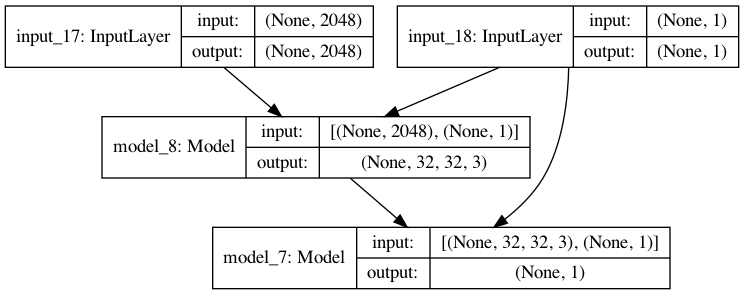

In [98]:
d_model = discriminator()
d_model.compile(loss=['binary_crossentropy'], optimizer=Adam(lr=0.0002, beta_1=0.5))
d_model.trainable = False
g_model = generator()

noise = Input(shape=(noise_size, ))
label = Input(shape=(1, ))
img = g_model([noise, label])

valid = d_model([img, label])

combined = Model([noise, label], valid, name='gan_model_01')
combined.compile(loss=['binary_crossentropy'], optimizer=Adam(lr=0.001, beta_1=0.5))

combined.summary()
plot_model(combined, to_file='combined_plot.png', show_shapes=True, show_layer_names=True)

## Train process

In [87]:
def train(epochs):
    
    for epoch in range(epochs):
        
        random = np.random.randint(0, 11)
        
        for index in range(int(x.shape[0]/batch_size)):
            print(index, "in", range(int(x.shape[0]/batch_size)))         
                
            valid = np.ones((batch_size, 1)) - (np.random.random()*0.1)
            fake = np.zeros((batch_size, 1)) + (np.random.random()*0.1)
            
            x_train = x[index*batch_size : (index+1)*batch_size]
            y_train = y[index*batch_size : (index+1)*batch_size]
            x_train = (x_train - 127.5)/127.5
            
            if index % 100 == random:
                valid = np.zeros((batch_size, 1)) + (np.random.random()*0.1)
                fake = np.ones((batch_size, 1)) - (np.random.random()*0.1)
            
            noise = np.random.randn(batch_size, noise_size)
            gen_img = g_model.predict([noise, y_train])
                        
            d_loss_real = d_model.train_on_batch([x_train, y_train], valid)
            d_loss_fake = d_model.train_on_batch([gen_img, y_train], fake)
            d_loss = 0.5*(np.add(d_loss_real, d_loss_fake))

            sample_label = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            valid = np.ones((batch_size, 1))
            
            g_loss = combined.train_on_batch([noise, sample_label], valid)

            if index % (batch_size) == 0:
                print(index)
                print("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss))
                sample_images(epoch)
                # Actualizo las gráficas cada plt_frq iteraciones
            
            losses["g"].append(g_loss)
            losses["d"].append(d_loss)
            
        plot_loss(losses)
                
        name = './weights/combined_' + str(epoch) + '.h5'
        combined.save_weights(name)
        
        time.sleep(30)

## Generate sample images

In [88]:
def sample_images(epoch):
    r = 2
    c = 5
    noise = np.random.randn(10, noise_size)
    sample_label = np.arange(0, 10).reshape(-1, 1)
            
    gen_img = g_model.predict([noise, sample_label])
        
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = image.array_to_img(gen_img[cnt])
            axs[i,j].imshow(img)
            axs[i,j].set_title("Class: %d" % sample_label[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

## Plot loss from training

In [89]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='Pérdida del discriminador')
        plt.plot(losses["g"], label='Pérdida del generador')
        plt.legend()
        plt.show()

In [90]:
losses = {"d":[], "g":[]}

## Train!

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

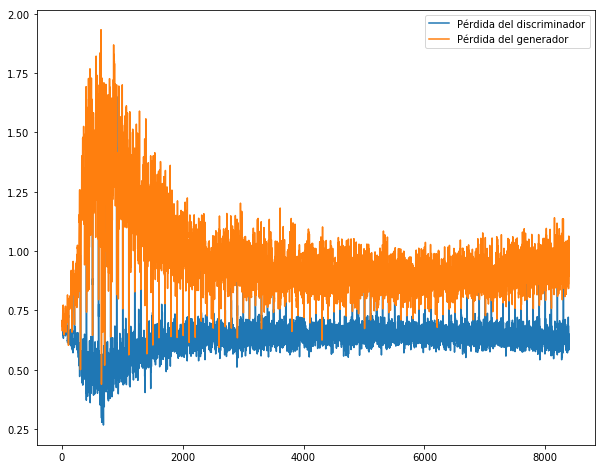

0 in range(0, 1200)
0
7 [D loss: 0.608174] [G loss: 1.061670]
1 in range(0, 1200)
2 in range(0, 1200)
3 in range(0, 1200)
4 in range(0, 1200)
5 in range(0, 1200)
6 in range(0, 1200)
7 in range(0, 1200)
8 in range(0, 1200)
9 in range(0, 1200)
10 in range(0, 1200)
11 in range(0, 1200)
12 in range(0, 1200)
13 in range(0, 1200)
14 in range(0, 1200)
15 in range(0, 1200)
16 in range(0, 1200)
17 in range(0, 1200)
18 in range(0, 1200)
19 in range(0, 1200)
20 in range(0, 1200)
21 in range(0, 1200)
22 in range(0, 1200)
23 in range(0, 1200)
24 in range(0, 1200)
25 in range(0, 1200)
26 in range(0, 1200)
27 in range(0, 1200)
28 in range(0, 1200)
29 in range(0, 1200)
30 in range(0, 1200)
31 in range(0, 1200)
32 in range(0, 1200)
33 in range(0, 1200)
34 in range(0, 1200)
35 in range(0, 1200)
36 in range(0, 1200)
37 in range(0, 1200)
38 in range(0, 1200)
39 in range(0, 1200)
40 in range(0, 1200)
41 in range(0, 1200)
42 in range(0, 1200)
43 in range(0, 1200)
44 in range(0, 1200)
45 in range(0, 1200)
46

362 in range(0, 1200)
363 in range(0, 1200)
364 in range(0, 1200)
365 in range(0, 1200)
366 in range(0, 1200)
367 in range(0, 1200)
368 in range(0, 1200)
369 in range(0, 1200)
370 in range(0, 1200)
371 in range(0, 1200)
372 in range(0, 1200)
373 in range(0, 1200)
374 in range(0, 1200)
375 in range(0, 1200)
376 in range(0, 1200)
377 in range(0, 1200)
378 in range(0, 1200)
379 in range(0, 1200)
380 in range(0, 1200)
381 in range(0, 1200)
382 in range(0, 1200)
383 in range(0, 1200)
384 in range(0, 1200)
385 in range(0, 1200)
386 in range(0, 1200)
387 in range(0, 1200)
388 in range(0, 1200)
389 in range(0, 1200)
390 in range(0, 1200)
391 in range(0, 1200)
392 in range(0, 1200)
393 in range(0, 1200)
394 in range(0, 1200)
395 in range(0, 1200)
396 in range(0, 1200)
397 in range(0, 1200)
398 in range(0, 1200)
399 in range(0, 1200)
400 in range(0, 1200)
400
7 [D loss: 0.670665] [G loss: 0.913828]
401 in range(0, 1200)
402 in range(0, 1200)
403 in range(0, 1200)
404 in range(0, 1200)
405 in ran

In [ ]:
train(epochs=20)

In [99]:
# Cargar pesos entrenados
name = 'weights/combined_12.h5'
combined.load_weights(name)

In [92]:
labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

In [93]:
labels[0]

'Airplane'

In [94]:
def predict():
    r = 2
    c = 5
    noise = np.random.randn(10, noise_size)
    sample_label = np.arange(0, 10).reshape(-1, 1)
            
    gen_img = g_model.predict([noise, sample_label])
        
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = image.array_to_img(gen_img[cnt])
            axs[i,j].imshow(img)
            #axs[i,j].set_title("Class: %d" % sample_label[cnt])
            axs[i,j].set_title(labels[sample_label[cnt][0]])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()        
    plt.close()

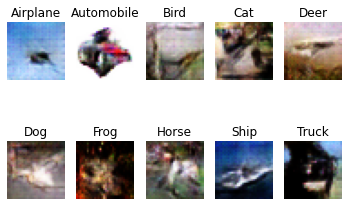

In [95]:
predict()

In [96]:
def predictOne(label=0):
    noise = np.random.randn(1, noise_size)
    sample_label = np.arange(0, 1).reshape(-1, 1)
    gen_img = g_model.predict([noise, sample_label])
    cnt = 0
    img = image.array_to_img(gen_img[label])
    plt.imshow(img)
    print(labels[sample_label[label][0]])
    plt.axis('off')
    plt.show()        
    plt.close()

Airplane


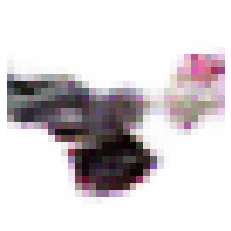

In [97]:
predictOne()

In [51]:
import requests
def sendTelegram(message, token=my_token):
    try:
        url = 'https://api.telegram.org/bot%s/sendMessage?chat_id=10626525&text=%s' % (my_token, message)
        r = requests.post(url) 
        r.raise_for_status() 
        return { 'status': 'OK' }
    except Exception as err:
        print("Error in url %s: message: %s" % (url, err))
        return { 'error': str(err) }

In [52]:
sendTelegram('Prueba')

{'status': 'OK'}

In [111]:
new_model = keras.models.load_model('gan_model_01.h5')
new_model.summary()

Model: "gan_model_01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 32, 32, 3)    8526723     input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
model_7 (Model)                 (None, 1)            1577345     model_8[1][0]         